In [1]:
# Importing core libraries
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from time import time
import pprint
import joblib
from functools import partial

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

**1. Read historical prices**
----------------
This dataset provides historical data of APPLE INC. stock (AAPL). The data is available at a daily level. Currency is USD. Time frame cropped to 2010 to reduce amount of data processing. 


In [3]:
df = pd.read_csv('AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2010)].copy()

**2. Exploratory data analysis**
----------------


In [4]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

In [5]:
basic_EDA(df)

Number of Samples: 3078,
Number of Features: 7,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


In [6]:
df.head()

Date      Open      High       Low     Close  Adj Close     Volume
7331 2010-01-04  7.622500  7.660714  7.585000  7.643214   6.544689  493729600
7332 2010-01-05  7.664286  7.699643  7.616071  7.656429   6.556005  601904800
7333 2010-01-06  7.656429  7.686786  7.526786  7.534643   6.451723  552160000
7334 2010-01-07  7.562500  7.571429  7.466071  7.520714   6.439794  477131200
7335 2010-01-08  7.510714  7.571429  7.466429  7.570714   6.482609  447610800

**OHLC Chart** <br>

OHLC(open/high/low/close) chart provides a sense of the historical prices. Volume chart shows number of stocks traded each day

In [7]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

**Decomposition**

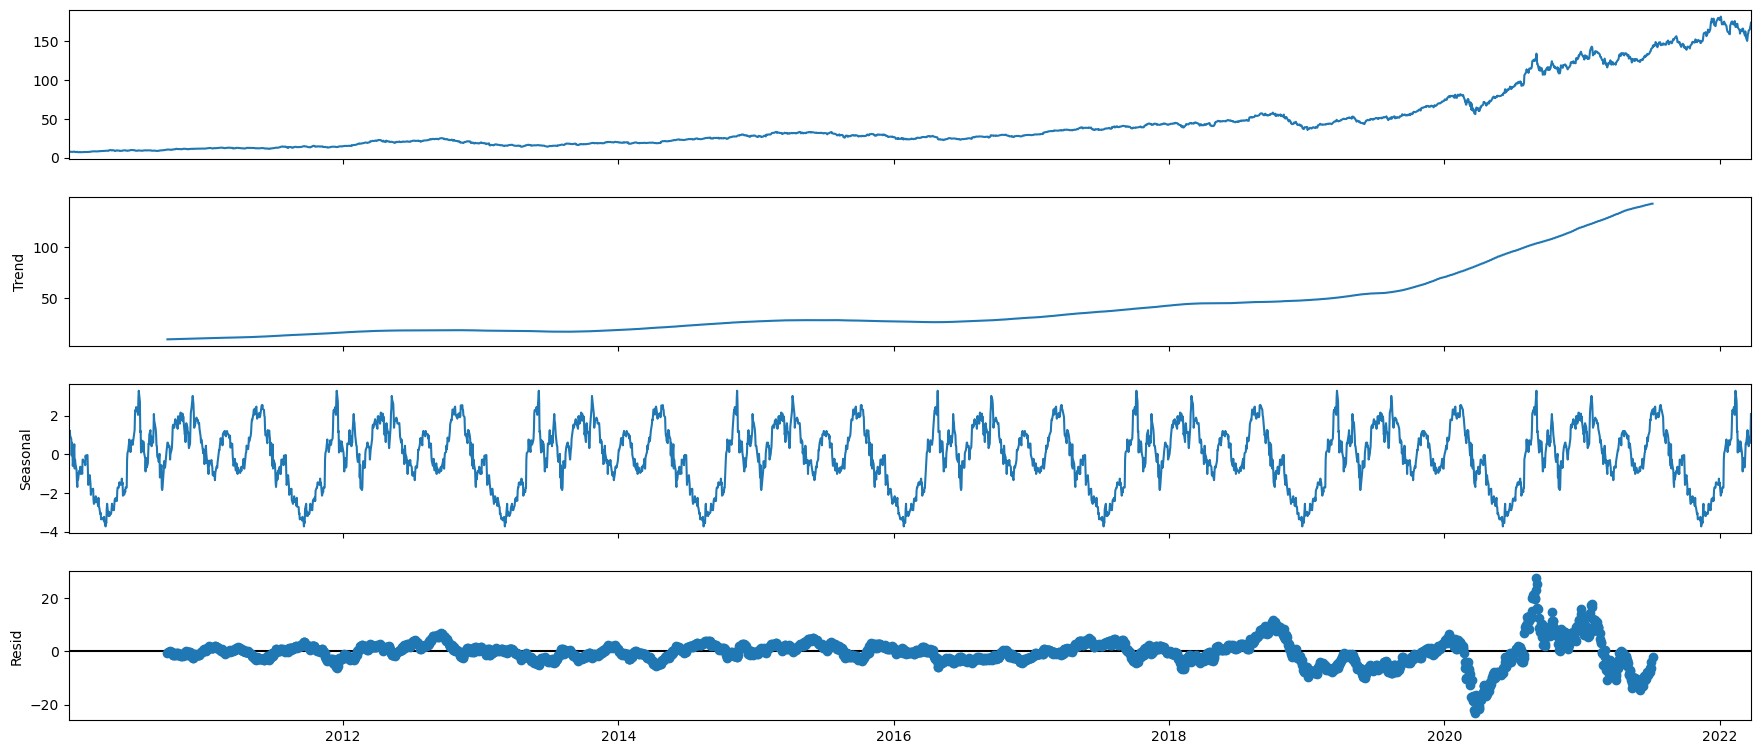

In [8]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = seasonal_decompose(df_close, model='additive', period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

**3. Preprocess the data**
----------------


Technical indicators
Moving Averages
I'm calculating few moving averages to be used as features:  $SMA_{5}$
 ,  $SMA_{10}$
 ,  $SMA_{15}$
 ,  $SMA_{30}$
  and  $EMA_{9}$
 .


In [9]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

**Relative strength indicator**
RSI indicator predicts whether a stock is overbought/oversold

In [10]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

**Moving average convergence/divergence(MACD)**

In [11]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

**Shift label column**<br>
To predict the next day price, after calculating all features for day Di
 ,shift Close price column by -1 rows.

In [12]:
df['Close'] = df['Close'].shift(-1)

**Drop invalid samples** <br>
Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated  $SMA$_{10}
  for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [13]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))
df.index

RangeIndex(start=0, stop=3044, step=1)

In [14]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Adj Close']
df1 = df.drop(drop_cols, axis = 1)
y = df1['Close'].copy()
X = df1.drop(['Close'], axis = 1)

**4. Partition the data**
----------------


In [15]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.3,  
                                   shuffle=True) 

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2130 entries, 939 to 69
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        2130 non-null   float64
 1   SMA_5        2130 non-null   float64
 2   SMA_10       2130 non-null   float64
 3   SMA_15       2130 non-null   float64
 4   SMA_30       2130 non-null   float64
 5   RSI          2130 non-null   float64
 6   MACD         2130 non-null   float64
 7   MACD_signal  2130 non-null   float64
dtypes: float64(8)
memory usage: 149.8 KB


**5. Baseline**
----------------


We will use the LightGBM implementation of the gradient boosting machine. This is much faster than the Scikit-Learn implementation and achieves results comparable to extreme gradient boosting, XGBoost. For the baseline model, We set up a generic LightGBM regressor.

In [17]:
# Setting the basic regressor
reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        metric='rmse',
                        objective='regression',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=0)

In [18]:
reg.fit(X_train, y_train) 
Y_train = reg.predict(X_train)
Y_test = reg.predict(X_test)

In [19]:
# Calculate and print the Root Mean Squared Error (RMSE) for training and test predictions. 
print("Training RMSE: ", np.sqrt(mean_squared_error(Y_train, y_train))) 
print("Test RMSE: ", np.sqrt(mean_squared_error(Y_test, y_test))) 

Training RMSE:  0.8168134518953944
Test RMSE:  1.523967783267528


**6. Bayesian optimisation** 
----------------

First, we create a wrapper function to deal with running the optimizer and reporting back its best results.

In [20]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performance of optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

We then define the evaluation metric, using the Scikit-learn function make_scorer allows us to convert the optimization into a minimization problem, as required by Scikit-optimize. We set squared=False by means of a partial function to obtain the root mean squared error (RMSE) as evaluation.

In [21]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

We set up a 5-fold cross validation

In [22]:
# Setting the validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=0)

We define a search space, expliciting the key hyper-parameters to optimize and the range where to look for the best values.

In [23]:
# Setting the search space
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'max_bin': Integer(100, 1000),                       # Max number of bins that feature values will be bucketed
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight (hessian) needed in a child (leaf)
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

We then define the Bayesian optimization engine, providing to it our LightGBM, the search spaces, the evaluation metric, the cross-validation. We set a large number of possible experiments and some parallelism in the search operations.

In [24]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=kf,                                           
                    n_iter=60,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

Finally we runt the optimizer and wait for the results. We have set some limits to its operations: we required it to stop if it cannot get consistent improvements from the search (DeltaYStopper) and time dealine set in seconds (we decided for 6 hours).

In [25]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 60 * 6) # We impose a time limit (6 hours)

best_params = report_perf(opt, X_train, y_train,'LightGBM_regression', 
                          callbacks=[overdone_control, time_limit_control])

LightGBM_regression took 187.85 seconds,  candidates checked: 60, best CV score: -1.413 ± 0.144
Best parameters:
OrderedDict([('colsample_bytree', 0.6689188045547757),
             ('learning_rate', 0.03240957307956568),
             ('max_bin', 1000),
             ('max_depth', 45),
             ('min_child_samples', 38),
             ('min_child_weight', 9.818654590000962),
             ('n_estimators', 1686),
             ('num_leaves', 142),
             ('reg_alpha', 5.3657135972608e-08),
             ('reg_lambda', 0.013386678276952219),
             ('subsample', 0.8418855504362726),
             ('subsample_freq', 0)])



**7. Prediction on test data**
----------------
Having got the best hyperparameters for the data at hand, we instantiate a lightGBM using such values and train our model.

In [26]:
# Transferring the best parameters to our basic regressor
reg_optim = lgb.LGBMRegressor(boosting_type='gbdt',
                        metric='rmse',
                        objective='regression',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=0,
                         **best_params)

In [27]:
# Fitting the regressor on the train data
reg_optim.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.6689188045547757,
              learning_rate=0.03240957307956568, max_bin=1000, max_depth=45,
              metric='rmse', min_child_samples=38,
              min_child_weight=9.818654590000962, n_estimators=1686, n_jobs=1,
              num_leaves=142, objective='regression', random_state=0,
              reg_alpha=5.3657135972608e-08, reg_lambda=0.013386678276952219,
              subsample=0.8418855504362726, verbose=-1)

In [28]:
Y_train = reg_optim.predict(X_train)
Y_test = reg_optim.predict(X_test)
print("Train RMSE: ", np.sqrt(mean_squared_error(Y_train, y_train))) 
print("Test RMSE: ", np.sqrt(mean_squared_error(Y_test, y_test))) 

Train RMSE:  0.5074131638079279
Test RMSE:  1.409571371758669
